In [2]:
import os
import sys  
import rasterio

import pandas as pd

from rasterio.plot import show

import numpy as np

#from PIL import Image

import numpy as np

import matplotlib.pyplot as plt

from geneticalgorithm import geneticalgorithm as ga

root = os.getcwd() + "/.."

sys.path.insert(0, root)
import src.camera_allocation_functions as aptitude

In [3]:

fp1 = '../data/processed/aguascalientes/00_clossenes_to_streets_normalized_ags'
walls = rasterio.open(fp1)

fp2 = '../data/processed/aguascalientes/01_densidad_delitos_sobre_calle_1998'
crime_density = rasterio.open(fp2)

fp3 = '../data/processed/aguascalientes/02_manzanas_raster_binary'
blocks = rasterio.open(fp3)

fp4 = '../data/processed/aguascalientes/delitos_ags_2018_raster_bin'
crime = rasterio.open(fp4)
C = crime.read(1)
#crime = crime_density.read(1)

#correction
S = blocks.read(1)
S[S==255] = 0

CD = crime_density.read(1)

W = walls.read(1)

Text(0.5, 0.98, 'Required Maps')

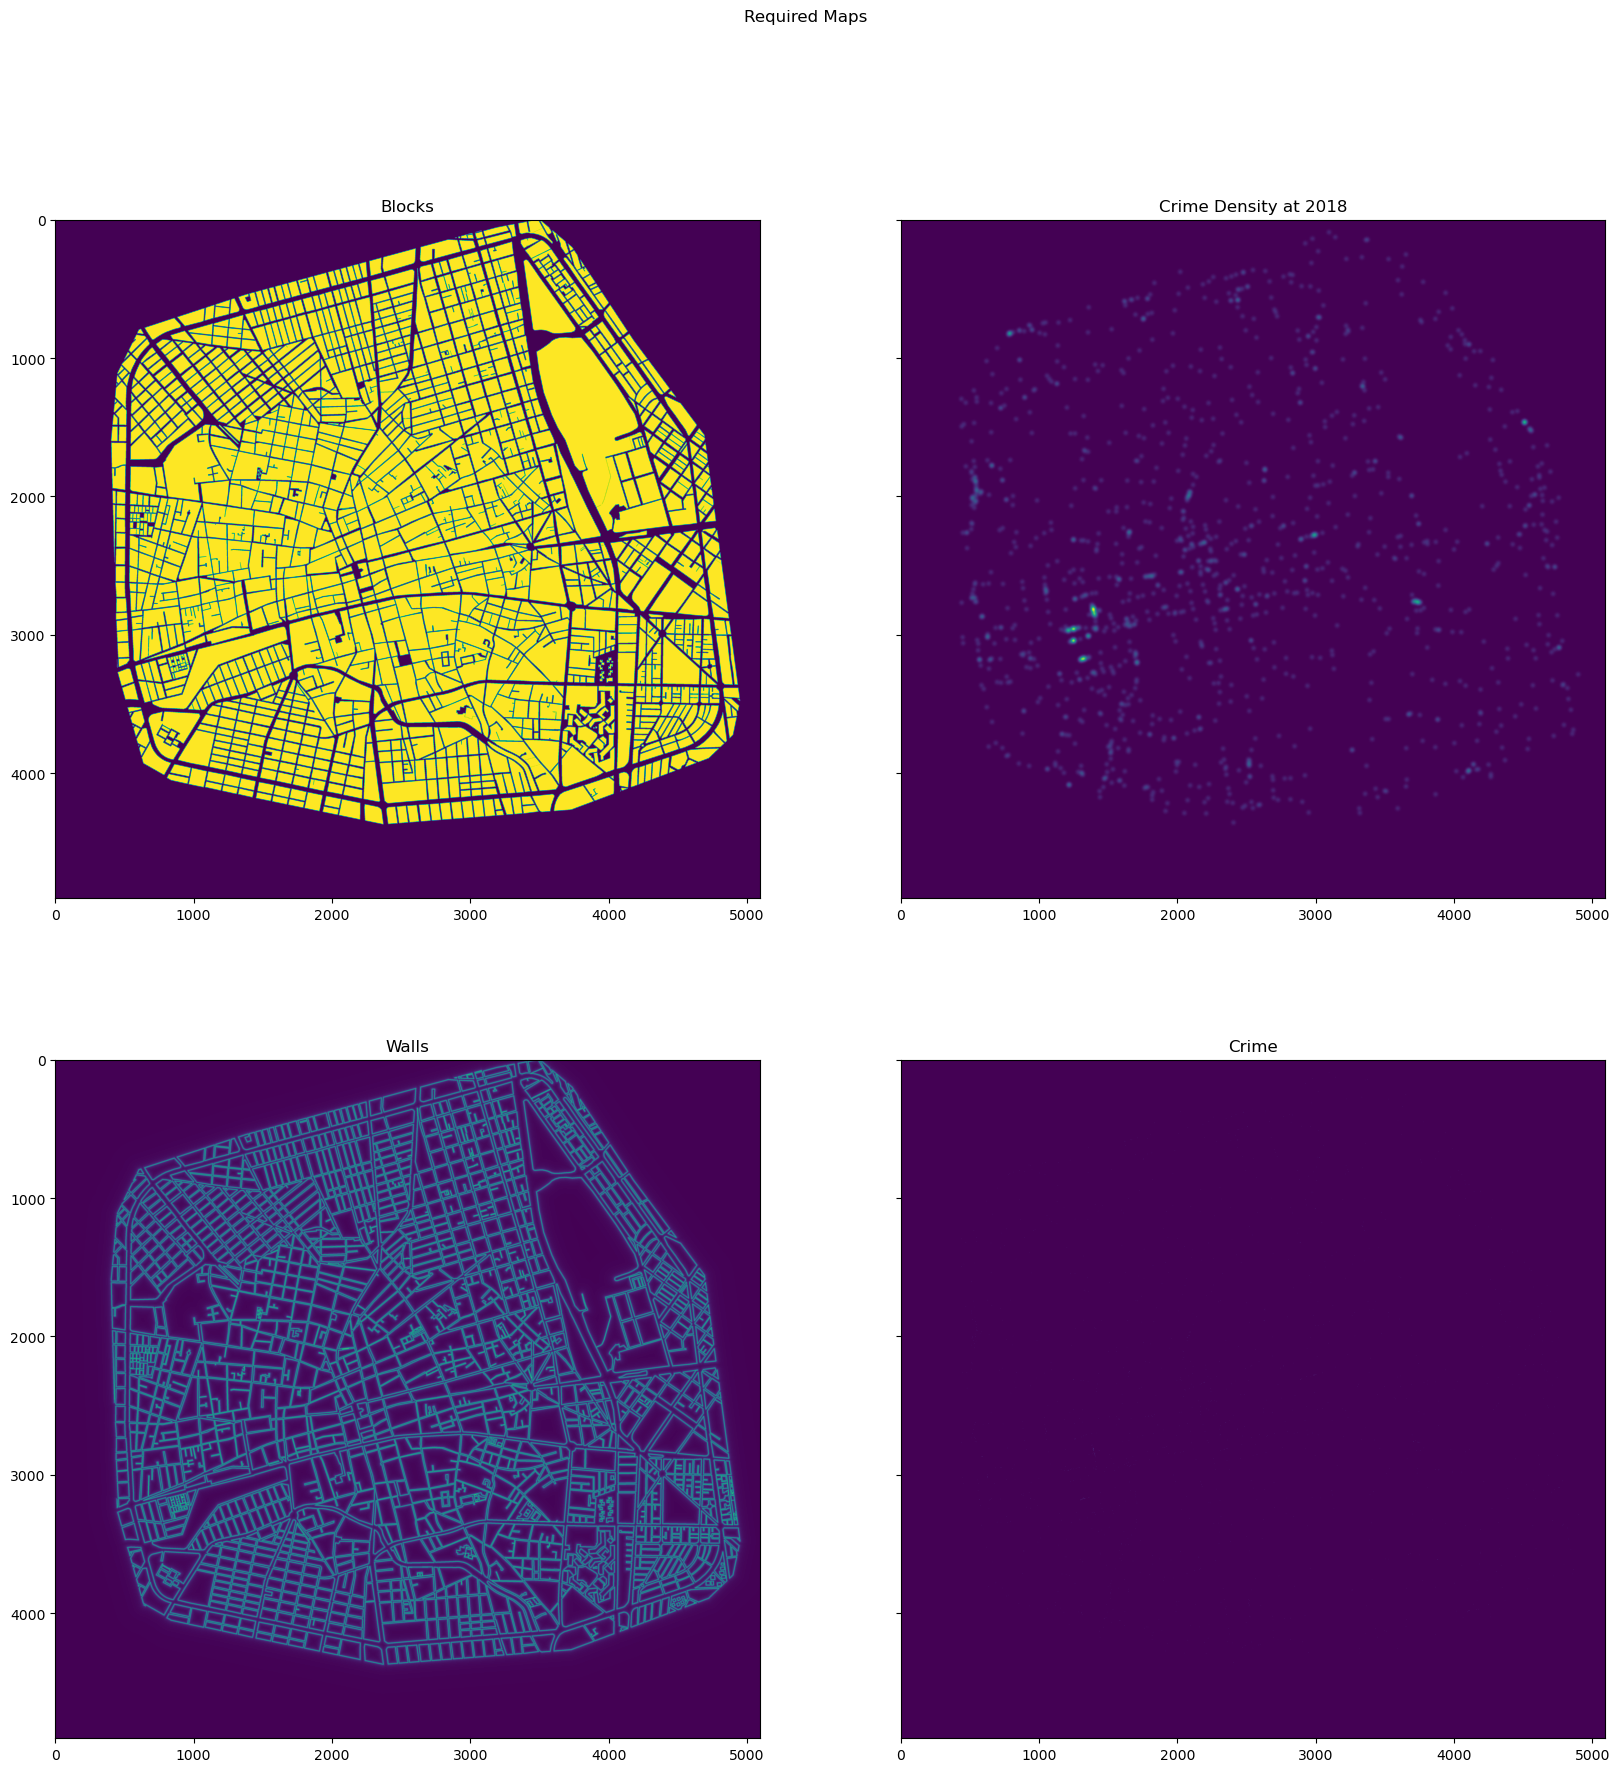

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
axs[0][0].imshow(S)
axs[0][0].set_title("Blocks")
axs[1][0].imshow(W)
axs[1][0].set_title("Walls")
axs[0][1].imshow(CD)
axs[0][1].set_title("Crime Density at 2018")
axs[1][1].imshow(C)
axs[1][1].set_title("Crime")
fig.suptitle('Required Maps')

In [36]:
DF = pd.read_csv("fitness_positions_vc_area.csv")



In [37]:
DF

,Unnamed: 0,visibility coefficient,area,i,j
0,0,0,0,0,0
1,1,100,200,90,80
2,2,100,200,90,80


In [22]:
#rank = "area"
rank = "visibility coefficient"
DF_sort = DF.sort_values(by = [rank], ascending = False)

,Unnamed: 0,visibility coefficient,area,i,j
0,0,0,0,0,0
1,1,100,200,90,80
2,2,100,200,90,80


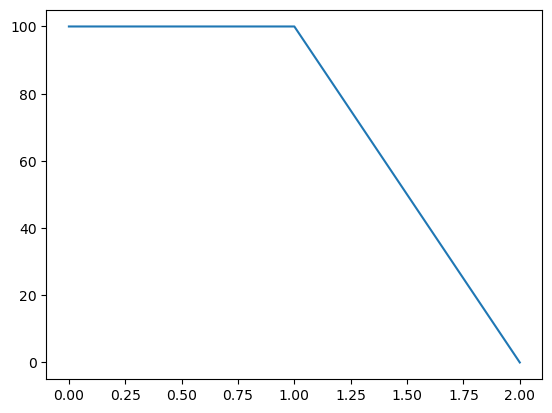

In [23]:
plt.plot(np.array(DF_sort[:][rank]))

#descartando las posiciones cercanas a la mejor

Algoritmo:
    
1. Ordenar las posiciones de acuerdo a su indice de visibilidad


In [24]:
# se debería llamar R de Radio
radius = 50

#Ordenar las posiciones de acuerdo a su indice de visibilidad (DF_init)

#seleccionar la mejor posición
i = 0

DF_init = DF_sort.iloc[[i]]

#recuperar las posiciones que están fuera del radio según su distancia euclideana
#una política (inventada) es que no puede haber dos camaras dentro de un radio de 50m
selected_rows = ((DF_sort.iloc[i]["i"] - DF_sort["i"])**2 + (DF_sort.iloc[i]["j"] - DF_sort["j"])**2)**(0.5) >= radius

#hacer una lista con las posiciones que estan fuera del radio
DF_sort = DF_sort[selected_rows]

#
c = 0

while len(DF_sort)>0 and np.sum(selected_rows) > 0:
    
    selected_rows = ((DF_sort.iloc[0]["i"] - DF_sort["i"])**2 + (DF_sort.iloc[0]["j"] - DF_sort["j"])**2)**(0.5)>=radius
   
    if np.sum(selected_rows) > 0:
    
        DF_sort = DF_sort[selected_rows]
        DF_init = pd.concat([DF_init, DF_sort.iloc[[0]]])
    
    if c%1000 == 0:  
        
        print(np.sum(selected_rows))
    
    c += 1
        

0


In [33]:
DF_sort

,Unnamed: 0,visibility coefficient,area,i,j
0,0,0,0,0,0


In [28]:
#nmax = 10
#ixs = np.arange(len(DF_sort))
#np.random.shuffle(ixs)



In [29]:
n_sensors = 100
Xresh = np.array(DF_init.iloc[:n_sensors][["i","j"]]).astype(int)


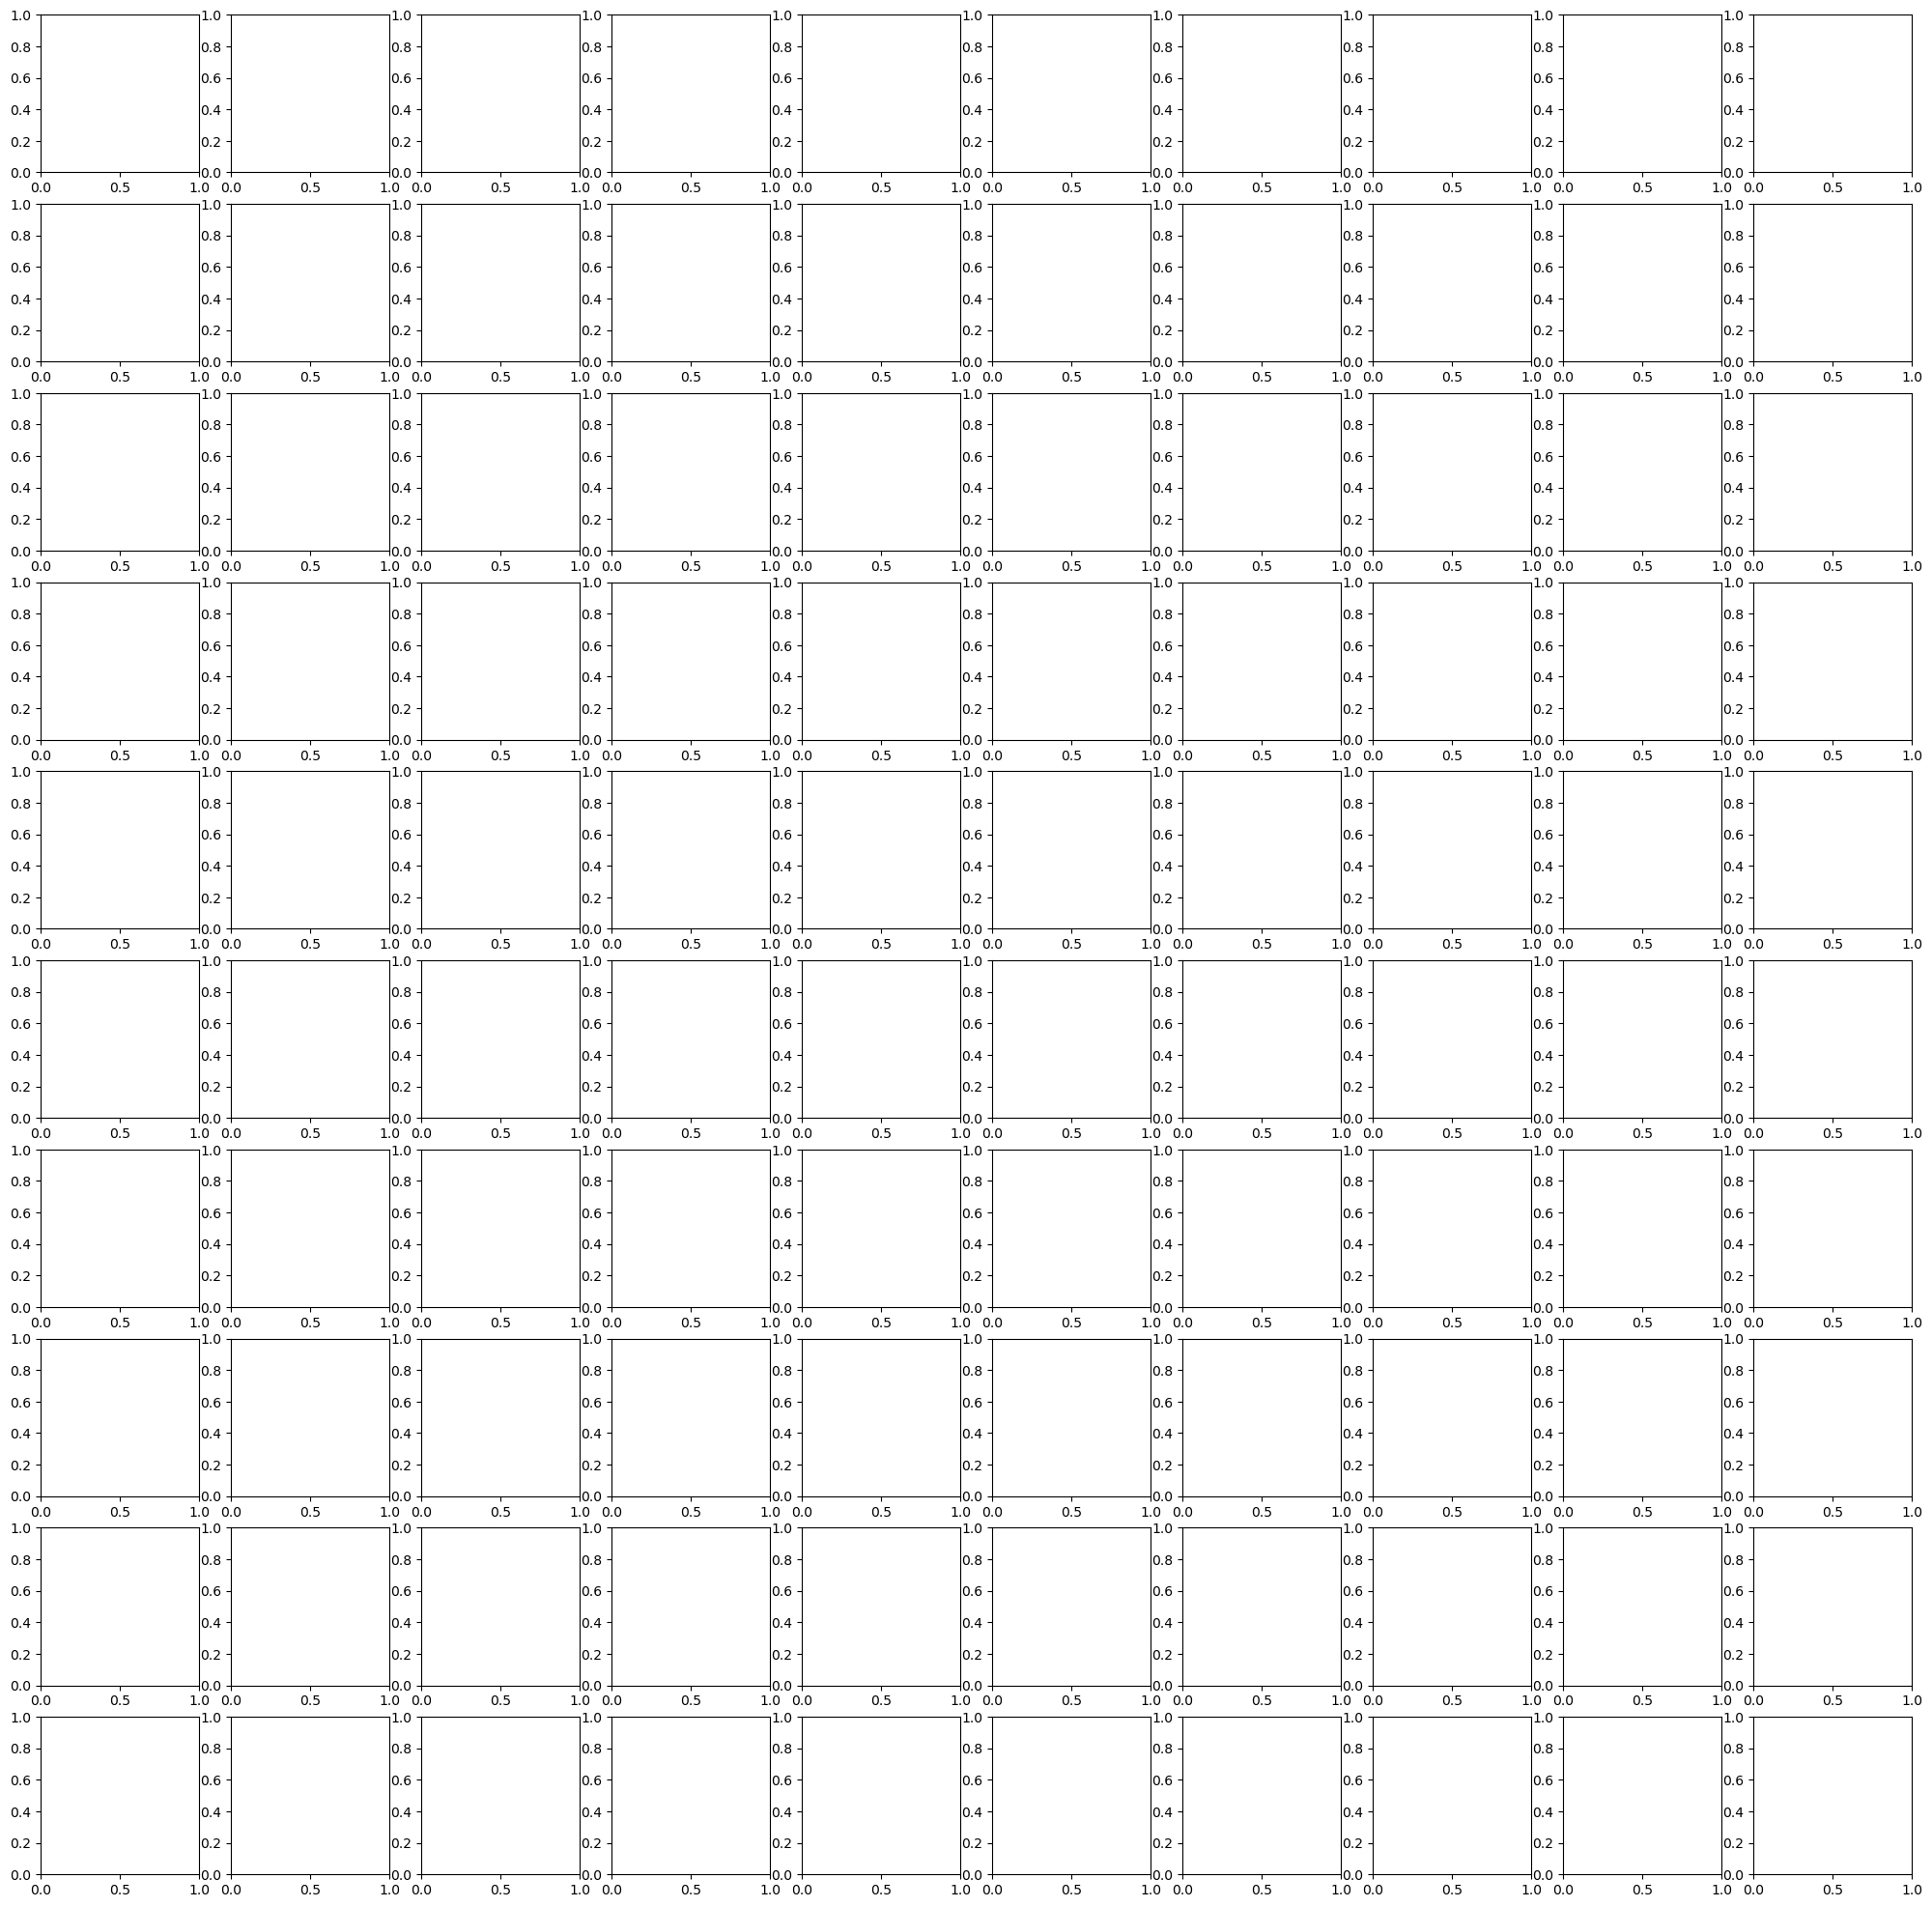

In [30]:
COVERS = np.zeros((n_sensors+1, S.shape[0], S.shape[1]))

fig, axs = plt.subplots(10, 10, figsize=(25, 25))

for i, x in enumerate(Xresh[1:]):
    
    si = tuple(x)
   # print(si)
    
    Z = np.zeros((radius*2+1, radius*2+1))
    Z[(radius*2, radius*2)] = 1
    
    S_sub = np.copy(S[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    CD_sub = np.copy(CD[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    C_sub = np.copy(C[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
    isovist = aptitude.isovista(S_sub)
    K = aptitude.gkern(radius*2 + 1, 4)
    Kth = 0.000001
    
    # esta es la línea que calcula el número de delitos (C_sub) dentro del radio de visión  de la camara (K>th) y su isovista (isovist)
    #indice de observabilidad de densidad de delitos: isovist*K*CD_sub
    #COVERS[i+1, si[0]-radius : si[0] + radius + 1, si[1]-radius:si[1]+radius+1] = C_sub*(K>Kth)*isovist
    
    COVERS[i+1, si[0]-radius : si[0] + radius + 1, si[1]-radius:si[1]+radius+1] = isovist*K*CD_sub
    
    #plt.imshow(isovist*K*CD_sub)
    #plt.show()
    

    axs[int(i/10), (i%10)].axis('off')  # Turn off the axis
    # Example: Placing different text in each subplot
    axs[int((i)/10), (i%10)].imshow(isovist+C_sub)
    axs[int((i)/10), (i%10)].set_title(np.sum(C_sub))
    
max_covers = np.max(COVERS, axis=0)
arg_max_covers = np.argmax(COVERS, axis=0)

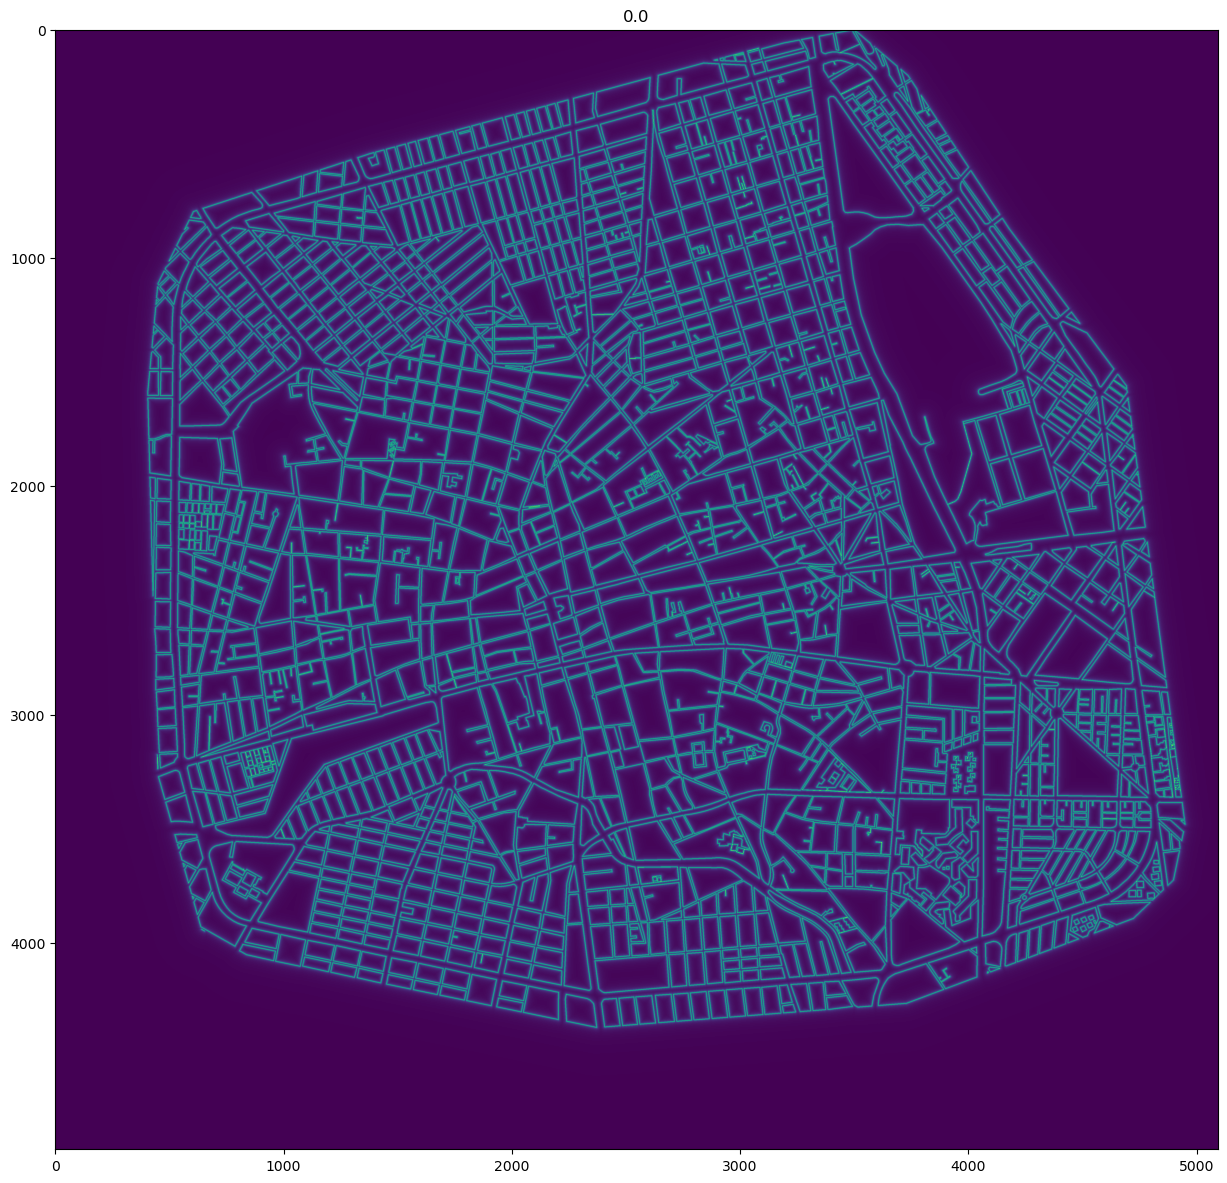

In [13]:
plt.figure(figsize=(15, 15))
plt.imshow(max_covers+W/600000)
plt.title(np.sum(max_covers))
plt.show()

In [14]:
n = 10

X = np.array([ np.random.randint(S.shape) for i in range(100)])
X = X.flatten()

# Greedy Algorithm

In [15]:
def f(X, S = S):
    
    radius = 50
    Xresh = X.reshape(2, -1).astype(int)
    
    COVERS = np.zeros((n_sensors + 1, S.shape[0], S.shape[1]))

    for i, x in enumerate(Xresh):

        si = tuple(x)

        Z = np.zeros((radius*2+1, radius*2+1))
        Z[(radius*2, radius*2)] = 1

        S_sub = np.copy(S[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
        CD_sub = np.copy(CD[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
        C_sub = np.copy(C[si[0] - radius:si[0] + radius + 1, si[1] - radius:si[1] + radius + 1])
        isovist = aptitude.isovista(S_sub)
        K = aptitude.gkern(radius*2 + 1, 4)
        Kth = 0.000001

        # esta es la línea que calcula el número de delitos (C_sub) dentro del radio de visión  de la camara (K>th) y su isovista (isovist)
        #indice de observabilidad de densidad de delitos: isovist*K*CD_sub
        #COVERS[i+1, si[0]-radius : si[0] + radius + 1, si[1]-radius:si[1]+radius+1] = C_sub*(K>Kth)*isovist

        COVERS[i+1, si[0]-radius : si[0] + radius + 1, si[1]-radius:si[1]+radius+1] = isovist*K*CD_sub

    s = np.sum(np.max(COVERS, axis=0))
   # print(s)
    return -s

    

In [16]:
radius = 50

n_sensors = n

varbound = np.array([[radius, S.shape[0]-radius-1], [radius, S.shape[1]-radius-1]]*n_sensors)

dim = len(varbound)

dim

20

In [17]:
algorithm_parameters = {"max_num_iteration": 100, 
                        "population_size": 1000, 
                        "mutation_probability": 0.1, 
                        "elit_ratio": 0.1, 
                        "crossover_probability": 0.5, 
                        "parents_portion": 0.3, 
                        "crossover_type": 
                        "uniform", 
                        "max_iteration_without_improv": 20}

In [18]:
model = ga(function = f,
             dimension = dim,
             algorithm_parameters = algorithm_parameters,
             variable_type = 'int',
             variable_boundaries = varbound,
             convergence_curve = True)

In [19]:
model.run()

||||______________________________________________ 7.0% GA is running...

KeyboardInterrupt: 

In [ ]:
model.output_dict["variable"].astype(int).reshape(-1,2)

In [ ]:
model.output_dict

**Notas e Hipotesis**

* No necesariamente cubrir mas área es cubrir mas delitos
* Hay un compromiso de cubrir area vs densidad de delitos



**Contando los delitos dentro del radio de la isovista de la camara**

In [ ]:
np.sum(max_covers)

In [ ]:
plt.imshow(isovist*K*CD_sub)

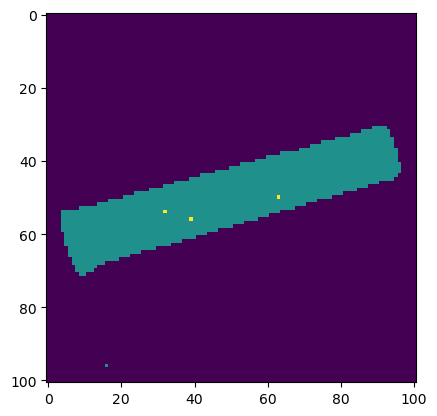

In [20]:
plt.imshow(C_sub+(isovist*(K>0.000001)))

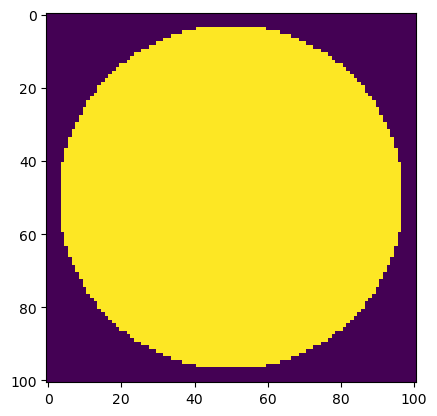

In [21]:
#radio de visión de una camara 360
plt.imshow(K>0.000001)

Text(0.5, 1.0, 'número de delitos : 3')

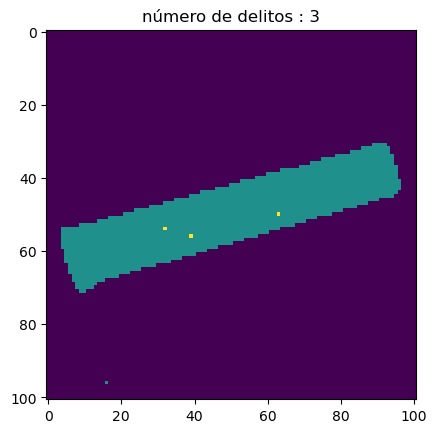

In [22]:
# delitos detectados dentro del radio de visión y la isovista
plt.imshow(C_sub+(isovist*(K>0.000001)))
plt.title("número de delitos : {n}".format( n= np.sum((C_sub*isovist*K>0.000001))))

In [ ]:
# delitos detectados dentro del radio de visión y la isovista
plt.imshow(C_sub+(isovist*(K>0.000001)))
plt.title("número de delitos : {n}".format( n= np.sum((C_sub*isovist*K>0.000001))))

In [15]:
Que es deseable en con un operador de mutacion - cruza?

Y_{G+1} = P(G,\theta)


max \theta ( evaluate(P(Y_G,\theta)) - evaluate(Y_{G}) )

maximizar la probabilidad de mejorar en general la función objetivo en la siguiente iteracion



SyntaxError: invalid syntax (2220799539.py, line 3)